In [43]:
from config.params import *
from src import explore_data_structure
import numpy as np
import pandas as pd
!pip install shapely


sample_file = SAMPLE_FILE
df_original = explore_data_structure(sample_file)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.5 MB/s eta 0:00:0000:0100:01
📊 Data Structure Analysis
Subject ID: 1024539343
Total samples: 45,010
Columns: 24
Recording duration: 90.02 seconds
Effective sampling rate: 500.0 Hz

📋 Column Information:
Column                    Type       Missing %  Description
----------------------------------------------------------------------
timestamp                 int64      0.0        Recording timestamp (ms)
frame_number              float64    0.0        Video frame number
x_left                    float64    1.1        Left eye X coordinate
y_left                    float64    1.1        Left eye Y coordinate
pupil_left                float64    1.1        Left pupil diameter
x_right                   float64    0.9        Right eye X coordinate
y_right                   float64    0.9        Right eye Y coordinate
pupil_right               float64    0.9        Right pupil diameter
input                     float64    100.0      Ad

In [2]:
df_original.describe()

,timestamp,frame_number,x_left,y_left,pupil_left,x_right,y_right,pupil_right,input,cr_left,cr_right,head_movement_left_x,head_movement_right_x,head_movement_magnitude,inter_pupil_distance,gaze_velocity_left,gaze_velocity_right
count,45010.00000,45008.000000,44531.000000,44531.000000,44531.000000,44590.000000,44590.000000,44590.000000,0.0,45010.000000,45010.000000,44531.000000,44590.000000,44260.000000,44260.000000,44520.000000,44586.000000
mean,614193.00000,1350.766553,851.903285,420.344023,1142.365880,815.101204,401.408731,643.265710,NaN,5258.098578,1844.027083,-4407.676378,-1026.476571,4529.414595,90.245701,1613.402068,1566.785170
std,25986.82429,779.564185,285.844760,198.067412,208.134321,252.443711,173.795574,211.422899,NaN,416.845541,136.280913,477.539064,255.627406,498.259418,155.187601,10762.748976,3863.508244
min,569184.00000,1.000000,-1267.800000,-941.100000,46.000000,-511.000000,0.000000,37.000000,NaN,4155.000000,1563.000000,-7059.700000,-2647.800000,3274.878395,2.408319,0.000000,0.000000
25%,591688.50000,676.000000,678.500000,234.300000,1023.000000,629.200000,251.100000,524.000000,NaN,5096.000000,1766.000000,-4657.000000,-1205.400000,4252.129784,62.118717,111.803399,250.000000
50%,614193.00000,1351.000000,897.800000,456.200000,1108.000000,846.200000,417.400000,604.000000,NaN,5370.000000,1815.000000,-4450.400000,-988.900000,4542.809019,71.919782,180.277564,502.493781
75%,636697.50000,2026.000000,1045.400000,543.000000,1224.000000,1002.500000,497.300000,735.000000,NaN,5536.000000,1887.000000,-4153.800000,-833.100000,4777.252590,82.480801,304.138127,1154.339638
max,659202.00000,2697.000000,2492.700000,1560.800000,5353.000000,1676.600000,1299.100000,1917.000000,NaN,5854.000000,2227.000000,-3238.300000,-210.900000,7218.170248,2778.529131,551986.560072,263747.540273


In [3]:
from os.path import basename
subject_id = basename(SAMPLE_FILE).split('_')[0]
subject_id

'1024539343'

In [4]:
df = df_original.copy()
missing_proportion = df.isnull().sum() / len(df)
missing_proportion

timestamp                  0.000000
frame_number               0.000044
x_left                     0.010642
y_left                     0.010642
pupil_left                 0.010642
x_right                    0.009331
y_right                    0.009331
pupil_right                0.009331
input                      1.000000
cr_info                    0.995046
cr_left                    0.000000
cr_right                   0.000000
head_movement_left_x       0.010642
head_movement_right_x      0.009331
head_movement_magnitude    0.016663
inter_pupil_distance       0.016663
gaze_velocity_left         0.010886
gaze_velocity_right        0.009420
is_fixation_left           0.000000
is_fixation_right          0.000000
is_saccade_left            0.000000
is_saccade_right           0.000000
is_blink_left              0.000000
is_blink_right             0.000000
dtype: float64

In [5]:
cols_to_remove = missing_proportion[missing_proportion > PREPROCESSING_PARAMS['missing_data_threshold']].index.tolist()
cols_to_remove

['input', 'cr_info']

In [6]:
df_populated_cols = df.drop(columns=cols_to_remove)

Some cells has only one eye data gaze coordinates we can add the other eye estimation based on mean/median of distance between eyes when we have both eyes data. We now create a df that contains all eyes gaze coordinates

In [7]:
valid_eyes_coordinates = df_populated_cols[['x_left', 'y_left', 'x_right', 'y_right']].copy()
valid_eyes_coordinates.dropna()
#calc Euclidean distance
distances_before = np.sqrt(
    (valid_eyes_coordinates['x_right'] - valid_eyes_coordinates['x_left'])**2 +
    (valid_eyes_coordinates['y_right'] - valid_eyes_coordinates['y_left'])**2
)
distances_before.median()

71.91978170087927

However, the data contains calibration issues and other possible artifacts. We should remove implausible distances between the gaze coordinates, based on the knowledge that subjects sat 60 cm from a 19-inch screen with 1280×1024 resolution (with no chin rest). We can calculate this distance easily. We applied a 20-100 pixel threshold which aligns with physiological expectations for children viewing at 60 cm distance. With interpupillary distances of 40-60 mm, the calculated convergence angle (1.9-5.7°) corresponds to 20-100 pixels on this display, effectively filtering tracking errors while preserving valid binocular data.

In [8]:
# Calculate Euclidean distance between left and right eye coordinates
valid_eyes_coordinates['gaze_distance'] = np.sqrt(
    (valid_eyes_coordinates['x_right'] - valid_eyes_coordinates['x_left'])**2 +
    (valid_eyes_coordinates['y_right'] - valid_eyes_coordinates['y_left'])**2
)
valid_eyes_coordinates.describe()

,x_left,y_left,x_right,y_right,gaze_distance
count,44531.000000,44531.000000,44590.000000,44590.000000,44260.000000
mean,851.903285,420.344023,815.101204,401.408731,90.245701
std,285.844760,198.067412,252.443711,173.795574,155.187601
min,-1267.800000,-941.100000,-511.000000,0.000000,2.408319
25%,678.500000,234.300000,629.200000,251.100000,62.118717
50%,897.800000,456.200000,846.200000,417.400000,71.919782
75%,1045.400000,543.000000,1002.500000,497.300000,82.480801
max,2492.700000,1560.800000,1676.600000,1299.100000,2778.529131


In [9]:
valid_eyes_coordinates_distance = valid_eyes_coordinates[(valid_eyes_coordinates['gaze_distance'] >= 20) & (valid_eyes_coordinates['gaze_distance'] <= 100)].copy()
# valid_eyes_coordinates_distance.describe()
valid_eyes_coordinates_distance.describe()

,x_left,y_left,x_right,y_right,gaze_distance
count,38381.000000,38381.000000,38381.000000,38381.000000,38381.000000
mean,855.316962,405.663974,796.509536,391.443988,69.455632
std,243.811121,195.865748,244.110198,175.103949,14.410018
min,147.900000,-31.400000,64.800000,0.000000,20.000250
25%,674.000000,223.600000,619.800000,241.400000,61.974350
50%,887.800000,447.600000,835.300000,414.900000,70.677083
75%,1036.100000,526.800000,974.400000,496.300000,78.680684
max,1356.400000,1059.100000,1366.600000,1034.100000,99.988899


We lost some data:

In [10]:
rejected_data = valid_eyes_coordinates[
    (valid_eyes_coordinates['gaze_distance'] < 20) | 
    (valid_eyes_coordinates['gaze_distance'] > 120)
].copy()
rejected_data.describe()

,x_left,y_left,x_right,y_right,gaze_distance
count,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000
mean,747.794347,483.001924,921.881429,437.698990,274.816174
std,521.485335,192.650029,260.572465,123.754191,465.128189
min,-1267.800000,-348.300000,-470.800000,126.800000,2.408319
25%,737.200000,385.100000,756.600000,373.200000,17.584652
50%,852.000000,493.600000,952.200000,404.800000,136.371625
75%,1034.800000,600.100000,1105.200000,476.000000,226.645737
max,2492.700000,1128.400000,1637.600000,1054.300000,2778.529131


this mean is ≈ 6.65 cm on screen

Loss percentage: 13.28%


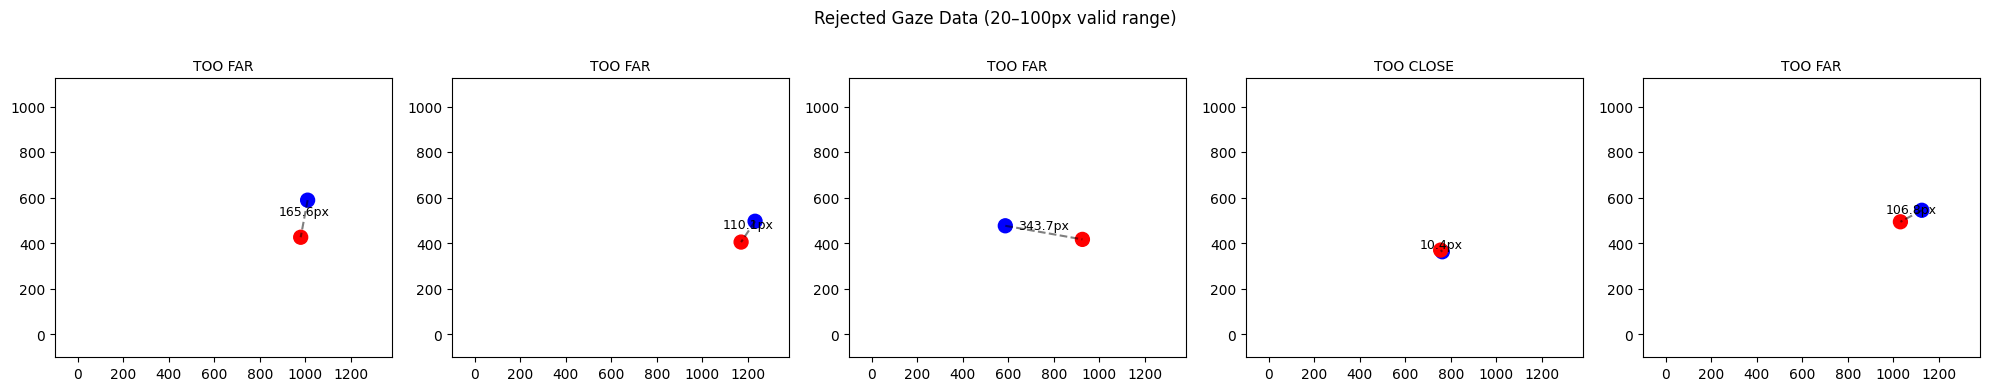

Total rejected: 5879 | Too close: 1314 | Too far: 4565
Min: 2.4px | Max: 2778.5px | Mean: 226.0px


In [11]:
import matplotlib.pyplot as plt
import numpy as np

print(
    f"Loss percentage: {(valid_eyes_coordinates['gaze_distance'].count() - valid_eyes_coordinates_distance['gaze_distance'].count()) / valid_eyes_coordinates['gaze_distance'].count() * 100:.2f}%")




def visualize_rejected_gaze_data(df, coords, num_examples=5):
    mask = (coords['gaze_distance'] < 20) | (coords['gaze_distance'] > 100)
    data = coords[mask].dropna()
    if data.empty:
        print("No rejected data found!"); return

    samples = np.random.choice(data.index, min(num_examples, len(data)), replace=False)
    fig, axes = plt.subplots(1, len(samples), figsize=(4*len(samples), 4))
    axes = np.atleast_1d(axes)

    for ax, idx in zip(axes, samples):
        row = data.loc[idx]
        ax.scatter([row['x_left'], row['x_right']], [row['y_left'], row['y_right']], c=['blue', 'red'], s=100)
        ax.plot([row['x_left'], row['x_right']], [row['y_left'], row['y_right']], 'k--', alpha=0.5)
        ax.text((row['x_left'] + row['x_right']) / 2, (row['y_left'] + row['y_right']) / 2,
                f"{row['gaze_distance']:.1f}px", ha='center', va='bottom', fontsize=9)
        ax.set_xlim(-100, 1380)
        ax.set_ylim(-100, 1124)
        ax.set_aspect('equal')
        ax.set_title(f"{'TOO CLOSE' if row['gaze_distance'] < 20 else 'TOO FAR'}", fontsize=10)
    
    plt.suptitle('Rejected Gaze Data (20–100px valid range)')
    plt.tight_layout()
    plt.show()

    print(f"Total rejected: {mask.sum()} | Too close: {(coords['gaze_distance'] < 20).sum()} | Too far: {(coords['gaze_distance'] > 100).sum()}")
    print(f"Min: {data['gaze_distance'].min():.1f}px | Max: {data['gaze_distance'].max():.1f}px | Mean: {data['gaze_distance'].mean():.1f}px")

    
visualize_rejected_gaze_data(df, valid_eyes_coordinates, num_examples=5)

Since that are some artifacts and calibration issues it will be safer the use the median to interpolate missing eyes coordinates values. lets see the new median:

In [12]:
distances_after = np.sqrt(
    (valid_eyes_coordinates_distance['x_right'] - valid_eyes_coordinates_distance['x_left'])**2 +
    (valid_eyes_coordinates_distance['y_right'] - valid_eyes_coordinates_distance['y_left'])**2
)
distances_before.median() - distances_after.median()

1.2426991351705539

small insignificant change.. 

In [13]:
df_interpolated = df_populated_cols.copy()

def interpolate_missing_eye_coordinates(available_eye, median_x, median_y, df):
    missing_eye = 'right' if available_eye == 'left' else 'left'

    missing_cols = [f'x_{missing_eye}', f'y_{missing_eye}']
    available_cols = [f'x_{available_eye}', f'y_{available_eye}']

    mask = (df[missing_cols].isna().any(axis=1) &
            df[available_cols].notna().all(axis=1))

    # Direction: left->right uses positive offset, right->left uses negative
    sign = 1 if available_eye == 'left' else -1

    df.loc[mask, missing_cols[0]] = df.loc[mask, available_cols[0]] + sign * median_x
    df.loc[mask, missing_cols[1]] = df.loc[mask, available_cols[1]] + sign * median_y

    return mask.sum()

median_x = (valid_eyes_coordinates_distance['x_right'] - valid_eyes_coordinates_distance['x_left']).abs().median()
median_y = (valid_eyes_coordinates_distance['y_right'] - valid_eyes_coordinates_distance['y_left']).abs().median()

total_interpolated = (interpolate_missing_eye_coordinates('left', median_x, median_y, df_interpolated) +
                     interpolate_missing_eye_coordinates('right', median_x, median_y, df_interpolated))
print(f"Data quality report: {total_interpolated}/{len(df)} rows ({total_interpolated/len(df)*100:.1f}%) needed interpolation")

Data quality report: 601/45010 rows (1.3%) needed interpolation


In [14]:
df_interpolated.describe()

,timestamp,frame_number,x_left,y_left,pupil_left,x_right,y_right,pupil_right,cr_left,cr_right,head_movement_left_x,head_movement_right_x,head_movement_magnitude,inter_pupil_distance,gaze_velocity_left,gaze_velocity_right
count,45010.00000,45008.000000,44861.000000,44861.000000,44531.000000,44861.000000,44861.000000,44590.000000,45010.000000,45010.000000,44531.000000,44590.000000,44260.000000,44260.000000,44520.000000,44586.000000
mean,614193.00000,1350.766553,849.934092,422.194951,1142.365880,814.507989,403.113310,643.265710,5258.098578,1844.027083,-4407.676378,-1026.476571,4529.414595,90.245701,1613.402068,1566.785170
std,25986.82429,779.564185,288.658313,200.331806,208.134321,253.536667,175.893865,211.422899,416.845541,136.280913,477.539064,255.627406,498.259418,155.187601,10762.748976,3863.508244
min,569184.00000,1.000000,-1267.800000,-941.100000,46.000000,-511.000000,-911.900000,37.000000,4155.000000,1563.000000,-7059.700000,-2647.800000,3274.878395,2.408319,0.000000,0.000000
25%,591688.50000,676.000000,676.700000,234.600000,1023.000000,627.700000,251.400000,524.000000,5096.000000,1766.000000,-4657.000000,-1205.400000,4252.129784,62.118717,111.803399,250.000000
50%,614193.00000,1351.000000,894.900000,457.000000,1108.000000,846.000000,418.600000,604.000000,5370.000000,1815.000000,-4450.400000,-988.900000,4542.809019,71.919782,180.277564,502.493781
75%,636697.50000,2026.000000,1045.200000,544.000000,1224.000000,1003.300000,499.000000,735.000000,5536.000000,1887.000000,-4153.800000,-833.100000,4777.252590,82.480801,304.138127,1154.339638
max,659202.00000,2697.000000,2492.700000,1560.800000,5353.000000,1676.600000,1590.000000,1917.000000,5854.000000,2227.000000,-3238.300000,-210.900000,7218.170248,2778.529131,551986.560072,263747.540273


we now add new features based on the ones we already have in out df

In [15]:
df_enriched = df_interpolated.copy()
df_enriched['time_seconds'] = (df_enriched['timestamp'] - df_enriched['timestamp'].iloc[0]) / 1000.0
df_enriched['disparity_x'] = df_enriched['x_left'] - df_enriched['x_right']
df_enriched['disparity_y'] = df_enriched['y_left'] - df_enriched['y_right']
df_enriched['disparity_total'] = np.sqrt(df_enriched['disparity_x']**2 + df_enriched['disparity_y']**2)
df_enriched['both_eyes_valid'] = (df_enriched['x_left'].notna() & df_enriched['x_right'].notna() & df_enriched['y_left'].notna() & df_enriched['y_right'].notna())

at this point we have a dataframe where all samples that has eye coordinate has an insterpolated when based on the median of the tistance bewenn valid samples with both eyes gaze coordintas

In [16]:
window_size = 100
df_stabilized = df_enriched.copy()

# 1. Movement consistency - how smooth is each eye's movement
df_stabilized['left_velocity_variance'] = df_stabilized['gaze_velocity_left'].rolling(window_size).var()
df_stabilized['right_velocity_variance'] = df_stabilized['gaze_velocity_right'].rolling(window_size).var()

# 2. Sudden jumps detection
df_stabilized['left_velocity_diff'] = df_stabilized['gaze_velocity_left'].diff().abs()
df_stabilized['right_velocity_diff'] = df_stabilized['gaze_velocity_right'].diff().abs()

# 3. Signal stability (using position variance)
df_stabilized['left_position_variance'] = (
    df_stabilized['x_left'].rolling(window_size).var() + 
    df_stabilized['y_left'].rolling(window_size).var()
)
df_stabilized['right_position_variance'] = (
    df_stabilized['x_right'].rolling(window_size).var() + 
    df_stabilized['y_right'].rolling(window_size).var()
)

df_stabilized[['left_velocity_variance','right_velocity_variance','left_position_variance','right_position_variance']]
df_stabilized[df_stabilized['right_velocity_variance'].notnull()]

,timestamp,frame_number,x_left,y_left,pupil_left,x_right,y_right,pupil_right,cr_left,cr_right,...,disparity_x,disparity_y,disparity_total,both_eyes_valid,left_velocity_variance,right_velocity_variance,left_velocity_diff,right_velocity_diff,left_position_variance,right_position_variance
99,569382,6.0,665.4,498.4,2386.0,659.0,556.5,1907.0,4647.0,1994.0,...,6.4,-58.1,58.451433,True,NaN,5.351680e+03,3.037467e+02,0.000000,103730.463276,1.336190
100,569384,6.0,665.6,498.3,2387.0,659.0,556.5,1907.0,4647.0,1993.0,...,6.6,-58.2,58.573031,True,NaN,4.581531e+03,9.435188e+01,50.000000,103851.443232,1.331171
101,569386,7.0,665.7,498.2,2387.0,659.1,556.4,1908.0,4648.0,1992.0,...,6.6,-58.2,58.573031,True,NaN,4.594557e+03,4.109272e+01,70.710678,103971.358593,1.334768
102,569388,7.0,665.8,498.0,2387.0,659.1,556.3,1908.0,4649.0,1990.0,...,6.7,-58.3,58.683729,True,NaN,4.537322e+03,4.109272e+01,20.710678,104090.653393,1.346909
103,569390,7.0,666.0,497.9,2388.0,659.3,556.3,1909.0,4650.0,1989.0,...,6.7,-58.4,58.783076,True,NaN,4.312126e+03,5.083223e-11,50.000000,104209.744908,1.365813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44633,658450,2678.0,992.0,562.2,808.0,1292.9,551.9,65.0,5178.0,2181.0,...,-300.9,10.3,301.076236,True,2.245728e+07,3.724602e+07,9.950500e+03,4098.625477,20564.023300,18381.046003
44634,658452,2678.0,990.0,620.1,765.0,1294.6,598.4,54.0,5178.0,2181.0,...,-304.6,21.7,305.371986,True,2.921238e+07,3.889893e+07,5.365942e+03,5803.430625,21767.781749,19977.159227
44635,658454,2679.0,987.6,689.9,714.0,1294.9,602.8,38.0,5178.0,2181.0,...,-307.3,87.1,319.405229,True,3.923187e+07,3.875249e+07,5.953358e+03,21060.424739,23164.419207,21554.712053
44636,658456,2679.0,984.7,755.9,667.0,1294.9,602.8,38.0,5178.0,2181.0,...,-310.2,153.1,345.924341,True,4.785370e+07,3.891044e+07,1.888784e+03,2205.107707,24819.815607,23094.182540


In [17]:
first_timestamp = df_enriched['timestamp'].iloc[0]
df_enriched['seconds'] = (df_enriched['timestamp'] - first_timestamp) / 1000.0
df_enriched.columns

Index(['timestamp', 'frame_number', 'x_left', 'y_left', 'pupil_left',
       'x_right', 'y_right', 'pupil_right', 'cr_left', 'cr_right',
       'head_movement_left_x', 'head_movement_right_x',
       'head_movement_magnitude', 'inter_pupil_distance', 'gaze_velocity_left',
       'gaze_velocity_right', 'is_fixation_left', 'is_fixation_right',
       'is_saccade_left', 'is_saccade_right', 'is_blink_left',
       'is_blink_right', 'time_seconds', 'disparity_x', 'disparity_y',
       'disparity_total', 'both_eyes_valid', 'seconds'],
      dtype='object')

In [18]:
import matplotlib.pyplot as plt

def plot_simple_trajectory(df, start_time=14.5, end_time=16.5, figsize=(10, 10)):
    """
    Simple overlay plot of eye trajectories.
    """
    # Use the 'seconds' column
    time_col = 'seconds'
    
    if time_col not in df.columns:
        print(f"Error: '{time_col}' column not found")
        return
    
    # Filter time window
    mask = (df[time_col] >= start_time) & (df[time_col] <= end_time)
    window_df = df[mask]
    
    if len(window_df) == 0:
        print(f"No data in range {start_time}-{end_time}s")
        print(f"Available range: {df[time_col].min():.2f} to {df[time_col].max():.2f}s")
        return
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot trajectories
    ax.plot(window_df['x_left'], window_df['y_left'], 
            'b-', linewidth=2, alpha=0.7, label='Left Eye')
    ax.plot(window_df['x_right'], window_df['y_right'], 
            color='orange', linewidth=2, alpha=0.7, label='Right Eye')
    
    # Mark start/end
    for eye, color in [('left', 'blue'), ('right', 'orange')]:
        x_col = f'x_{eye}'
        y_col = f'y_{eye}'
        valid = window_df[x_col].notna() & window_df[y_col].notna()
        if valid.any():
            x_vals = window_df.loc[valid, x_col].values
            y_vals = window_df.loc[valid, y_col].values
            ax.scatter(x_vals[0], y_vals[0], color=color, s=150, 
                      marker='o', edgecolor='black', linewidth=2, zorder=5)
            ax.scatter(x_vals[-1], y_vals[-1], color=color, s=150, 
                      marker='X', edgecolor='black', linewidth=2, zorder=5)
    
    ax.set_title(f'Eye Trajectories ({start_time}-{end_time}s)', fontsize=14)
    ax.set_xlabel('X Position (pixels)')
    ax.set_ylabel('Y Position (pixels)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()


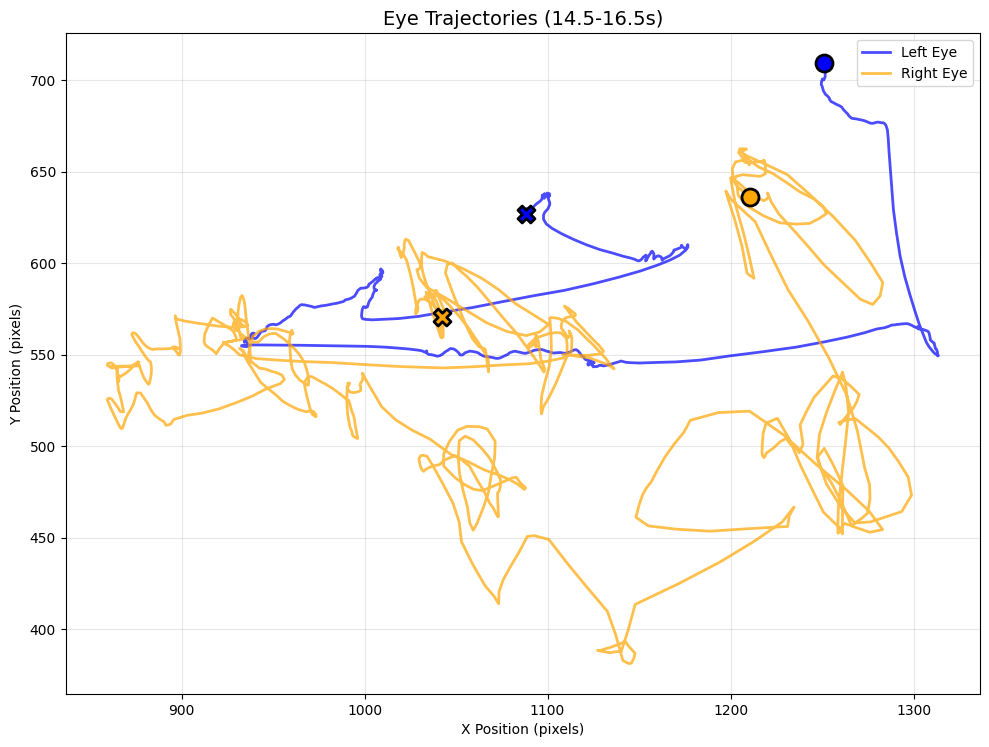

In [19]:
# a simple view at a very jerky eye tracking data of the right eye:
plot_simple_trajectory(df_enriched, start_time=14.5, end_time=16.5)


lets try to correct the eye instability issues. the approach will be:<br>

Given gaze velocity magnitude $v(t) = \sqrt{\dot{x}^2 + \dot{y}^2}$ (where $\dot{x}$ and $\dot{y}$ are the x and y components of velocity), jerk is computed as the second derivative of velocity magnitude with respect to time:

$$j(t) = \frac{d^2v(t)}{dt^2}$$

In the implementation, this is computed in discrete steps:

1. **Velocity magnitude** (given): $v(t) = \sqrt{\dot{x}^2 + \dot{y}^2}$

2. **Acceleration** (first derivative of velocity): $a(t) = \frac{dv(t)}{dt}$

3. **Jerk** (second derivative of velocity): $j(t) = \frac{da(t)}{dt} = \frac{d^2v(t)}{dt^2}$

For the jerk-based instability metric, the Root Mean Square (RMS) jerk is calculated over a sliding window of size $w$:

$$J_{\text{RMS}}(t) = \sqrt{\frac{1}{w}\sum_{i=t-w/2}^{t+w/2} j(i)^2}$$

This windowed RMS provides a smooth measure of local movement instability, where higher values indicate more erratic eye movements.


In [20]:
def simple_jerk_correction_clean(df, jerk_threshold=2.0, window_size=100):

    df_corrected = df.copy()
    dt = df['seconds'].diff().median()
    print(f"Time step: {dt:.4f}s ({1/dt:.1f} Hz)")
    
    # Calculate jerk and jerk ratios for both eyes
    print("Calculating jerk scores...")
    jerk_data = {}
    for eye in ['left', 'right']:
        if f'gaze_velocity_{eye}' in df_corrected.columns:
            velocity = np.nan_to_num(df_corrected[f'gaze_velocity_{eye}'].values, nan=0.0)
        else:
            dx = df_corrected[f'x_{eye}'].diff() / dt
            dy = df_corrected[f'y_{eye}'].diff() / dt
            velocity = np.sqrt(dx**2 + dy**2).fillna(0).values
        
        jerk = np.gradient(np.gradient(velocity)) 
        jerk_data[f'{eye}_jerk'] = pd.Series(jerk).rolling(
            window=window_size, center=True, min_periods=window_size//2
        ).apply(lambda x: np.sqrt(np.mean(x**2)))
    
    # Calculate jerk ratios
    epsilon = 1e-10
    left_jerk_ratio = jerk_data['left_jerk'] / (jerk_data['right_jerk'] + epsilon)
    right_jerk_ratio = jerk_data['right_jerk'] / (jerk_data['left_jerk'] + epsilon)
    
    # Calculate median disparity during stable periods
    stable_threshold = np.percentile(np.column_stack([jerk_data['left_jerk'], jerk_data['right_jerk']]), 25)
    stable_mask = (jerk_data['left_jerk'] < stable_threshold) & (jerk_data['right_jerk'] < stable_threshold)
    
    print(f"\nStable periods: {stable_mask.sum()} samples ({stable_mask.sum()/len(df)*100:.1f}%)")
    if stable_mask.sum() < 10:
        print("Warning: Very few stable periods found, using all data for disparity calculation")
        stable_mask = pd.Series([True] * len(df))
    
    median_disparity_x = np.nanmedian(df_corrected.loc[stable_mask, 'x_right'] - df_corrected.loc[stable_mask, 'x_left'])
    median_disparity_y = np.nanmedian(df_corrected.loc[stable_mask, 'y_right'] - df_corrected.loc[stable_mask, 'y_left'])
    print(f"Median disparity: X={median_disparity_x:.1f}, Y={median_disparity_y:.1f} pixels")
    
    # Apply corrections directly to the columns
    left_mask = left_jerk_ratio > jerk_threshold
    right_mask = right_jerk_ratio > jerk_threshold
    
    df_corrected.loc[left_mask, 'x_left'] = df_corrected.loc[left_mask, 'x_right'] - median_disparity_x
    df_corrected.loc[left_mask, 'y_left'] = df_corrected.loc[left_mask, 'y_right'] - median_disparity_y
    
    df_corrected.loc[right_mask, 'x_right'] = df_corrected.loc[right_mask, 'x_left'] + median_disparity_x
    df_corrected.loc[right_mask, 'y_right'] = df_corrected.loc[right_mask, 'y_left'] + median_disparity_y
    
    print(f"\nCorrections applied:")
    print(f"Left eye: {left_mask.sum()} samples ({left_mask.sum()/len(df)*100:.1f}%)")
    print(f"Right eye: {right_mask.sum()} samples ({right_mask.sum()/len(df)*100:.1f}%)")
    
    # Replace velocity columns with recalculated values
    for eye in ['left', 'right']:
        dx = df_corrected[f'x_{eye}'].diff() / dt
        dy = df_corrected[f'y_{eye}'].diff() / dt
        new_velocity = np.sqrt(dx**2 + dy**2)
        
        # Simply replace or create the velocity column
        df_corrected[f'gaze_velocity_{eye}'] = new_velocity

    df_corrected['left_jerk'] = jerk_data['left_jerk']
    df_corrected['right_jerk'] = jerk_data['right_jerk']
    df_corrected['left_jerk_ratio'] = left_jerk_ratio
    df_corrected['right_jerk_ratio'] = right_jerk_ratio

    return df_corrected

In [21]:
df_corrected = simple_jerk_correction_clean(df_enriched, jerk_threshold=2.0)

Time step: 0.0020s (500.0 Hz)
Calculating jerk scores...

Stable periods: 2953 samples (6.6%)
Median disparity: X=-62.9, Y=15.8 pixels

Corrections applied:
Left eye: 3134 samples (7.0%)
Right eye: 21503 samples (47.8%)


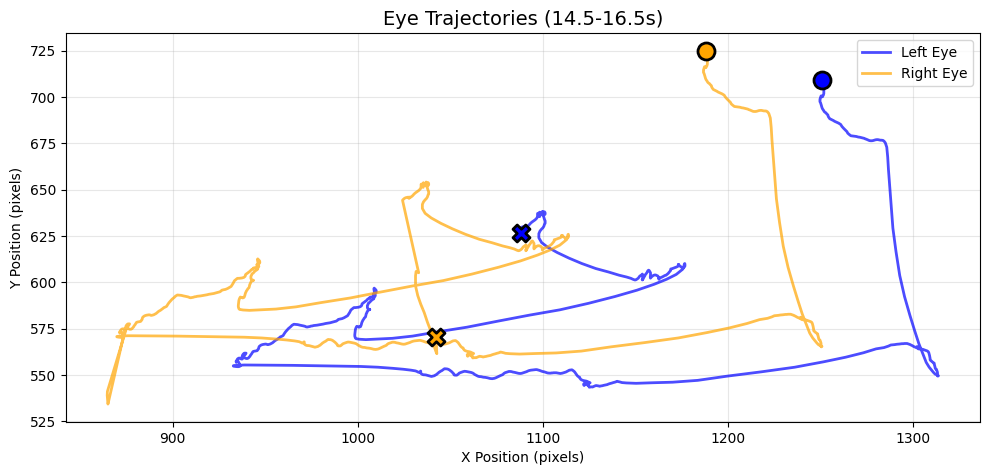

In [22]:
plot_simple_trajectory(df_corrected, start_time=14.5, end_time=16.5)


when the data is of low quality a deeper cleaning is required. we can use the jerkiness we calculated earlier to detect false saccade events due to low eye tracking quality. but first lets remove saccades events that dont make any sense ( 20 <= saccade duration <=200 [ms]) We now clean the  is_saccade_{left | right} column.

In [23]:
import pandas as pd
import numpy as np

def assign_saccade_durations(df, eye, sampling_rate):
    ms_per_sample = 1000 / sampling_rate
    duration_col = f'{eye}_saccade_duration'
    saccade_col = f'is_saccade_{eye}'

    df[duration_col] = 0
    i = 0
    while i < len(df):
        if df.iloc[i][saccade_col]:
            start_idx = i
            while i < len(df) and df.iloc[i][saccade_col]:
                i += 1
            end_idx = i - 1
            duration_ms = (end_idx - start_idx + 1) * ms_per_sample
            df.loc[start_idx:end_idx, duration_col] = duration_ms
        else:
            i += 1
    return df

def calculate_saccade_durations(df, sampling_rate=500):
    df = assign_saccade_durations(df, eye='left', sampling_rate=sampling_rate)
    df = assign_saccade_durations(df, eye='right', sampling_rate=sampling_rate)
    return df


def filter_invalid_saccades(df, min_duration=20, max_duration=200):
    df = df.copy()
    
    # Count original saccades
    original_left,original_right = df['is_saccade_left'].sum(),df['is_saccade_right'].sum()
    
    # Filter left saccades
    invalid_left = (df['is_saccade_left']) & \
                   ((df['left_saccade_duration'] < min_duration) | \
                    (df['left_saccade_duration'] > max_duration))
    df.loc[invalid_left, 'is_saccade_left'] = False
    
    # Filter right saccades
    invalid_right = (df['is_saccade_right']) & \
                    ((df['right_saccade_duration'] < min_duration) | \
                     (df['right_saccade_duration'] > max_duration))
    df.loc[invalid_right, 'is_saccade_right'] = False
    
    # Count filtered saccades
    filtered_left = invalid_left.sum()
    filtered_right = invalid_right.sum()
    
    # Print summary
    print(f"Saccade filtering summary (duration range: {min_duration}-{max_duration}ms):")
    print(f"Left eye:  {original_left} → {df['is_saccade_left'].sum()} samples ({filtered_left} filtered)")
    print(f"Right eye: {original_right} → {df['is_saccade_right'].sum()} samples ({filtered_right} filtered)")
    
    return df


# Main processing function
def process_saccades(df, min_duration=20, max_duration=200, sampling_rate=500):
    print("Processing saccades...")
    
    print(f"\nInitial saccade samples:")
    print(f"Left eye:  {df['is_saccade_left'].sum()}")
    print(f"Right eye: {df['is_saccade_right'].sum()}")
    
    # Calculate durations
    df = calculate_saccade_durations(df, sampling_rate)
    
# Filter invalid saccades
    print(f"\nFiltering saccades outside {min_duration}-{max_duration}ms range...")
    df = filter_invalid_saccades(df, min_duration, max_duration)
    
    return df


df_corrected_saccades = process_saccades(df_corrected, min_duration=20, max_duration=200, sampling_rate=500)


Processing saccades...

Initial saccade samples:
Left eye:  5135
Right eye: 8956

Filtering saccades outside 20-200ms range...
Saccade filtering summary (duration range: 20-200ms):
Left eye:  5135 → 4395 samples (740 filtered)
Right eye: 8956 → 4893 samples (4063 filtered)


At this point most of the data related to gaze movements, velocity and jerkiness, is quite clean, we can move on to handle pupils and blinks. pupil area is in arbitrary units, and it will be a good idea to normalize it.

In [24]:
def normalize_pupil_data(df):
    """Normalize pupil data to 0-1 range in place."""
    df = df.copy()
    
    for eye in ['left', 'right']:
        col = f'pupil_{eye}'
        # Normalize to 0-1 directly
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = (df[col] - min_val) / (max_val - min_val)
    
    return df

df_normalized_pupil = normalize_pupil_data(df_corrected_saccades)

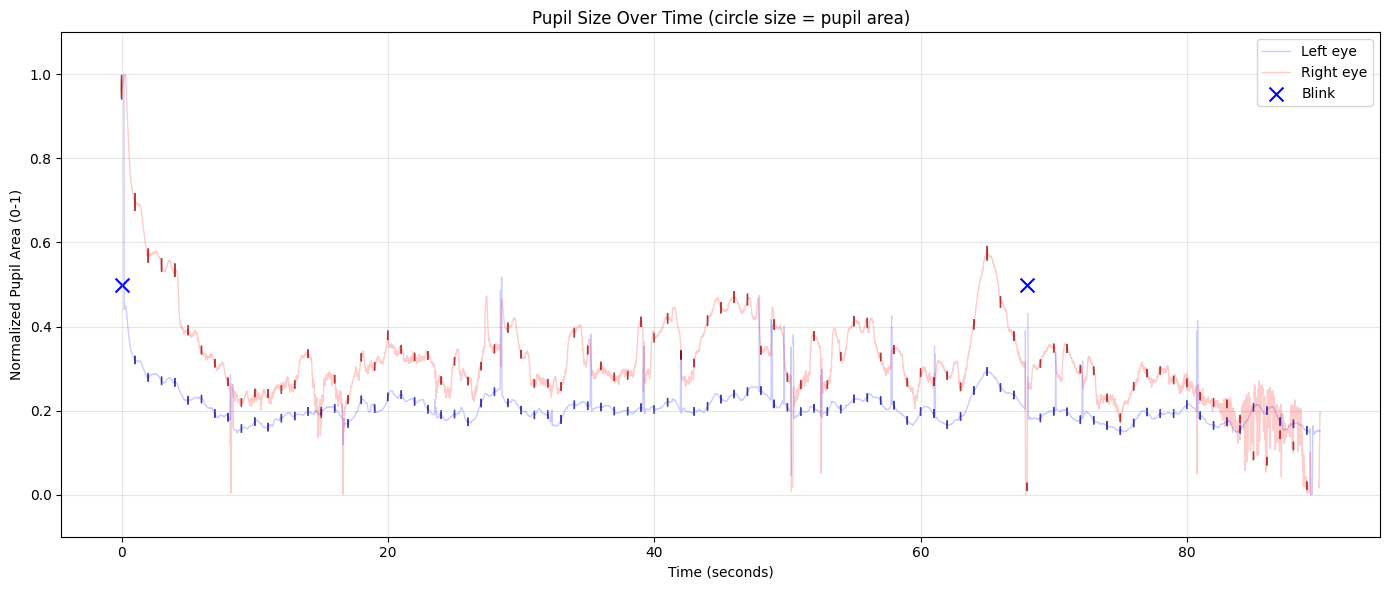

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def plot_pupil_circles(df, start_time=0, duration=30, sample_interval=1):
    # Select time window and sample
    mask = (df['seconds'] >= start_time) & (df['seconds'] < start_time + duration)
    data = df[mask].iloc[::int(sample_interval * 500)]  # Sample every second
    
    if len(data) == 0:
        print("No data in specified time range!")
        return
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot background lines
    ax.plot(df[mask]['seconds'], df[mask]['pupil_left'], 'b-', alpha=0.2, lw=1)
    ax.plot(df[mask]['seconds'], df[mask]['pupil_right'], 'r-', alpha=0.2, lw=1)
    
    # Add circles at sampled points
    for idx, row in data.iterrows():
        t = row['seconds']
        
        # Left eye (blue)
        if not row.get('is_blink_left', False) and not np.isnan(row['pupil_left']):
            size = row['pupil_left']
            circle_size = max(0.01, size * 0.03)
            ax.add_patch(Circle((t, size), circle_size, color='blue', alpha=0.7, ec='darkblue'))
        elif row.get('is_blink_left', False):
            ax.scatter(t, 0.5, marker='x', s=100, color='blue')
        
        # Right eye (red)
        if not row.get('is_blink_right', False) and not np.isnan(row['pupil_right']):
            size = row['pupil_right']
            circle_size = max(0.01, size * 0.03)
            ax.add_patch(Circle((t, size), circle_size, color='red', alpha=0.7, ec='darkred'))
        elif row.get('is_blink_right', False):
            ax.scatter(t, 0.5, marker='x', s=100, color='red')
    
    # Formatting
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Normalized Pupil Area (0-1)')
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3)
    ax.set_title('Pupil Size Over Time (circle size = pupil area)')
    ax.legend(['Left eye', 'Right eye', 'Blink'], loc='upper right')
    plt.tight_layout()
    plt.show()

plot_pupil_circles(df_normalized_pupil, start_time=0, duration=90, sample_interval=1)

 Mathematical Framework for Enhanced Pupil Data Cleaning

 1. Fundamental Definitions

 1.1 Pupil Dynamics Model
Given pupil diameter $p(t)$ at time $t$, normalized to range $[0,1]$:

**Pupil Velocity (Rate of Change)**
$v_p(t) = \frac{dp(t)}{dt} \approx \frac{p(t+\Delta t) - p(t-\Delta t)}{2\Delta t}$

where $\Delta t = 0.002$ seconds (sampling period)


**Pupil Acceleration**
$a_p(t) = \frac{d^2p(t)}{dt^2} = \frac{dv_p(t)}{dt} \approx \frac{v_p(t+\Delta t) - v_p(t-\Delta t)}{2\Delta t}$

 1.2 Physiological Constraints
Based on pupillary physiology:
- **Maximum velocity**: $|v_p(t)| \leq v_{max} = 0.5$ (normalized units/second)
  - *Visual interpretation: A velocity of 0.5 means the pupil can change up to 50% of its full range in one second - a physiologically plausible maximum*
- **Maximum acceleration**: $|a_p(t)| \leq a_{max} = 1.0$ (normalized units/second²)
- **Valid range**: $p(t) \in [0.1, 0.9]$ (extreme values indicate artifacts)

 2. Artifact Detection Framework

 2.1 Multi-Criteria Artifact Detection
An artifact is detected at time $t$ if any of the following conditions hold:

$$\text{Artifact}(t) = \begin{cases}
1 & \text{if } p(t) < 0.1 \text{ or } p(t) > 0.9 & \text{(extreme values)} \\
1 & \text{if } |p(t) - p(t-1)| > 0.1 & \text{(sudden jumps)} \\
1 & \text{if } |v_p(t)| > 0.5 \text{ or } |a_p(t)| > 1.0 & \text{(physics violation)} \\
0 & \text{otherwise}
\end{cases}$$

 2.2 Blink Detection and Modeling
Define blink indicator function $B(t) \in \{0,1\}$ where:
- $B(t) = 1$ indicates a blink at time $t$
- Blink start: $t_s$ where $B(t_s) = 1$ and $B(t_s-1) = 0$
- Blink end: $t_e$ where $B(t_e) = 0$ and $B(t_e-1) = 1$

 3. Blink Recovery Model

 3.1 Exponential Recovery Function
Post-blink pupil recovery follows an exponential model for $t > t_e$:

$p(t) = p_{baseline} \cdot (1 - e^{-\frac{t-t_e}{\tau}}) \quad \text{for } t \in [t_e, t_e + 500ms]$

where:
- $p_{baseline}$ = pre-blink pupil size (mean over 100ms before blink)
- $t_e$ = blink end time
- $\tau = 200ms$ = recovery time constant
- $t - t_e$ = time since blink ended

*Note: This models the recovery phase after the blink ends, not the blink closure itself.*

 3.2 Pre-blink Baseline Calculation
$$p_{baseline} = \frac{1}{n} \sum_{i=t_s-n}^{t_s-1} p(i)$$

where $n = 50$ samples (100ms at 500Hz)

 4. Stability Analysis

 4.1 Local Variability Metric
For a sliding window of size $w = 50$ samples (100ms):

$$\sigma_p(t) = \sqrt{\frac{1}{w} \sum_{i=t-w/2}^{t+w/2} (p(i) - \bar{p}_w(t))^2}$$

where $\bar{p}_w(t) = \frac{1}{w} \sum_{i=t-w/2}^{t+w/2} p(i)$

 4.2 Stable Period Detection
A time point $t$ is considered stable if both eyes show low variability:

$$\text{Stable}(t) = \begin{cases}
1 & \text{if } \sigma_{p_L}(t) < \tau_{stable} \text{ AND } \sigma_{p_R}(t) < \tau_{stable} \\
0 & \text{otherwise}
\end{cases}$$

where $\tau_{stable} = Q_{25}(\{\sigma_{p_L}, \sigma_{p_R}\})$ (25th percentile of all variabilities)

 5. Binocular Coordination Model

 5.1 Coupling Strength Calculation
The binocular coupling coefficient $\rho$ measures eye coordination:

$$\rho = \min\left(\max\left(\text{corr}(p_L(t), p_R(t))_{t \in S}, 0\right), 0.95\right)$$

where:
- $S = \{t : \text{Stable}(t) = 1\}$ (set of stable time points)
- $\text{corr}$ denotes Pearson correlation
- Bounds: $\rho \in [0, 0.95]$

 5.2 Adaptive Threshold Calculation
The acceptable binocular difference threshold adapts to coupling strength:

$\Delta p_{threshold} = Q_{\alpha}(\{|p_L(t) - p_R(t)| : t \in S\})$

where the percentile $\alpha$ depends on coupling:
$\alpha = 90 + 8(1 - \rho)$

This gives $\alpha \in [90, 98]$ as $\rho \in [0.95, 0]$:
- Strong coupling ($\rho \approx 0.95$): $\alpha \approx 90$ (stricter threshold)
- Weak coupling ($\rho \approx 0.5$): $\alpha \approx 94$ (more lenient)
- Very weak coupling ($\rho \approx 0$): $\alpha \approx 98$ (most lenient)

 5.3 Weighted Correction Strategy
When $|p_L(t) - p_R(t)| > \Delta p_{threshold}$, apply coupling-weighted correction:

If $\sigma_{p_L}(t) < \sigma_{p_R}(t)$ (left eye more stable):
$$p_R^{corrected}(t) = \rho \cdot p_L(t) + (1-\rho) \cdot p_R(t)$$

If $\sigma_{p_R}(t) < \sigma_{p_L}(t)$ (right eye more stable):
$$p_L^{corrected}(t) = \rho \cdot p_R(t) + (1-\rho) \cdot p_L(t)$$

 6. Signal Processing Pipeline

 6.1 Linear Interpolation
For gaps of length $n \leq 50$ samples between valid points $p(t_1)$ and $p(t_2)$:

$$p(t) = p(t_1) + \frac{p(t_2) - p(t_1)}{t_2 - t_1}(t - t_1), \quad t \in [t_1, t_2]$$

 6.2 Gaussian Smoothing
Apply Gaussian filter with kernel:

$$G(k) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{k^2}{2\sigma^2}}$$

where:
- $\sigma = \frac{w_{smooth}}{3} = \frac{250}{3} \approx 83.3$ samples
- $w_{smooth} = 250$ samples (500ms window)

 7. Complete Algorithm Summary

1. **Normalize**: $p_{norm} = \frac{p - p_{min}}{p_{max} - p_{min}}$

2. **Compute derivatives**: $v_p(t), a_p(t)$ using centered differences

3. **Detect artifacts**: Apply multi-criteria detection excluding blinks

4. **Model blinks**: Apply exponential recovery for long blinks (>10ms)

5. **Interpolate**: Fill gaps ≤100ms with linear interpolation

6. **Calculate stability**: Compute $\sigma_p(t)$ for both eyes

7. **Find coupling**: $\rho = \text{corr}(p_L, p_R)$ during stable periods

8. **Set adaptive threshold**: $\Delta p_{threshold} = Q_{90+8(1-\rho)}(\Delta p|_{stable})$

9. **Apply corrections**: Weighted binocular consistency based on $\rho$

10. **Smooth**: Convolve with Gaussian kernel


In [26]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

def calculate_binocular_coupling_strength(df, stable_mask):
    """
    Calculate how strongly the two eyes are coupled during stable periods.
    Returns a value between 0 and 1 indicating coupling strength.
    """
    if stable_mask.sum() < 50:  # Need enough data points
        return 0.8  # Default coupling strength
    
    # Calculate correlation during stable periods
    stable_data = df.loc[stable_mask, ['pupil_left', 'pupil_right']].dropna()
    if len(stable_data) > 10:
        correlation = stable_data.corr().iloc[0, 1]
        # Ensure it's positive and capped at 0.95
        coupling_strength = min(max(correlation, 0), 0.95)
        print(f"Binocular coupling strength: {coupling_strength:.3f}")
        return coupling_strength
    return 0.8

def model_blink_recovery(df, eye, blink_start_idx, blink_end_idx):
    """
    Model pupil recovery after a blink using exponential recovery.
    Pupils typically show rapid initial recovery then gradual return to baseline.
    """
    # Get pre-blink baseline (average of 100ms before blink)
    pre_blink_samples = 50  # 100ms at 500Hz
    if blink_start_idx >= pre_blink_samples:
        baseline = df[f'pupil_{eye}'].iloc[blink_start_idx-pre_blink_samples:blink_start_idx].mean()
    else:
        baseline = df[f'pupil_{eye}'].iloc[:blink_start_idx].mean()
    
    # Recovery parameters
    recovery_tau = 100  # Recovery time constant in samples (200ms)
    recovery_duration = min(250, len(df) - blink_end_idx)  # 500ms or until end
    
    if recovery_duration > 0:
        # Exponential recovery model: pupil(t) = baseline * (1 - exp(-t/tau))
        t = np.arange(recovery_duration)
        recovery_curve = baseline * (1 - np.exp(-t / recovery_tau))
        
        # Apply recovery model
        recovery_indices = np.arange(blink_end_idx, min(blink_end_idx + recovery_duration, len(df)))
        df.loc[recovery_indices, f'pupil_{eye}'] = recovery_curve[:len(recovery_indices)]
    
    return df

def clean_pupil_data(df, remove_first_seconds=1, gaussian_window=250):

    df_clean = df.copy()
    
    # 1. Exclude first second
    df_clean = df_clean[df_clean['seconds'] >= remove_first_seconds].copy()
    df_clean = df_clean.reset_index(drop=True)  # Reset index for easier handling
    
    # 2. Enhanced cleaning for each eye
    for eye in ['left', 'right']:
        col = f'pupil_{eye}'
        
        # v(t) = [p(t+1) - p(t-1)] / (2*dt)
        pupil_series = df_clean[col]
        velocity = (pupil_series.shift(-1) - pupil_series.shift(1)) / 2 * 500
        
        # For acceleration, use centered differences on velocity
        accel = (velocity.shift(-1) - velocity.shift(1)) / 2 * 500

        
        # Detect artifacts
        extreme_mask = (df_clean[col] < 0.1) | (df_clean[col] > 0.9)
        sudden_mask = df_clean[col].diff().abs() > 0.1
        physics_mask = (velocity.abs() > 0.5) | (accel.abs() > 1.0)
        
        # Identify blink sequences
        blink_mask = df_clean[f'is_blink_{eye}'].fillna(False)
        
        # Find blink start and end points
        blink_diff = blink_mask.astype(int).diff()
        blink_starts = df_clean.index[blink_diff == 1].tolist()
        blink_ends = df_clean.index[blink_diff == -1].tolist()
        
        # Ensure equal number of starts and ends
        if len(blink_starts) > len(blink_ends):
            blink_ends.append(len(df_clean) - 1)
        
        # Combined artifact mask (excluding blinks for now)
        artifact_mask = extreme_mask | sudden_mask | physics_mask
        
        # Set non-blink artifacts to NaN
        df_clean.loc[artifact_mask & ~blink_mask, col] = np.nan
        
        # Handle blinks with recovery model
        for start, end in zip(blink_starts, blink_ends):
            if end - start > 5:  # Only model longer blinks
                df_clean = model_blink_recovery(df_clean, eye, start, end)
            else:
                # For short blinks, use simple interpolation
                df_clean.loc[start:end, col] = np.nan
        
        # Interpolate remaining NaN values
        df_clean[col] = df_clean[col].interpolate(method='linear', limit=50)
        
        # Final smoothing
        valid_mask = ~df_clean[col].isna()
        if valid_mask.sum() > gaussian_window:
            sigma = gaussian_window / 3
            smoothed = gaussian_filter1d(df_clean.loc[valid_mask, col], sigma=sigma)
            df_clean.loc[valid_mask, col] = smoothed
        
        # Clip to valid range
        df_clean[col] = np.clip(df_clean[col], 0, 1)
    
    # 3. Enhanced binocular consistency with coupling strength
    window = 50  # 100ms window

    left_var = df_clean['pupil_left'].rolling(
        window, center=True, min_periods=window//2
    ).std()
    right_var = df_clean['pupil_right'].rolling(
        window, center=True, min_periods=window//2
    ).std()
    
    # Identify stable periods
    stable_threshold = np.nanpercentile(
        np.concatenate([left_var.dropna(), right_var.dropna()]), 25
    )
    stable_mask = (left_var < stable_threshold) & (right_var < stable_threshold)
    
    coupling_strength = calculate_binocular_coupling_strength(df_clean, stable_mask)
    
    # Calculate adaptive threshold based on coupling strength
    if stable_mask.sum() > 100:
        stable_diff = (df_clean.loc[stable_mask, 'pupil_left'] - 
                      df_clean.loc[stable_mask, 'pupil_right']).abs()
        
        # Adjust percentile based on coupling strength
        # Strong coupling -> stricter threshold (lower percentile)
        # Weak coupling -> more lenient threshold (higher percentile)
        percentile = 90 + (1 - coupling_strength) * 8  # Range: 90-98
        diff_threshold = np.nanpercentile(stable_diff, percentile)
        
        print(f"Adaptive binocular threshold ({percentile:.0f}th percentile): {diff_threshold:.3f}")
    else:
        diff_threshold = 0.15
        print(f"Using fallback threshold: {diff_threshold:.3f}")
    
    # Apply binocular consistency with coupling-weighted correction
    pupil_diff = (df_clean['pupil_left'] - df_clean['pupil_right']).abs()
    large_diff_mask = pupil_diff > diff_threshold
    
    # Weighted correction based on coupling strength
    for idx in df_clean[large_diff_mask].index:
        if idx in left_var.index and idx in right_var.index:
            if left_var[idx] < right_var[idx]:
                # Left eye more stable, but weight by coupling
                correction = df_clean.loc[idx, 'pupil_left']
                df_clean.loc[idx, 'pupil_right'] = (
                    coupling_strength * correction + 
                    (1 - coupling_strength) * df_clean.loc[idx, 'pupil_right']
                )
            else:
                # Right eye more stable
                correction = df_clean.loc[idx, 'pupil_right']
                df_clean.loc[idx, 'pupil_left'] = (
                    coupling_strength * correction + 
                    (1 - coupling_strength) * df_clean.loc[idx, 'pupil_left']
                )
    
    print(f"Cleaned {(large_diff_mask).sum()} binocular inconsistencies")
    
    return df_clean

df_clean_pupil = clean_pupil_data(df_normalized_pupil)

Binocular coupling strength: 0.948
Adaptive binocular threshold (90th percentile): 0.269
Cleaned 1679 binocular inconsistencies


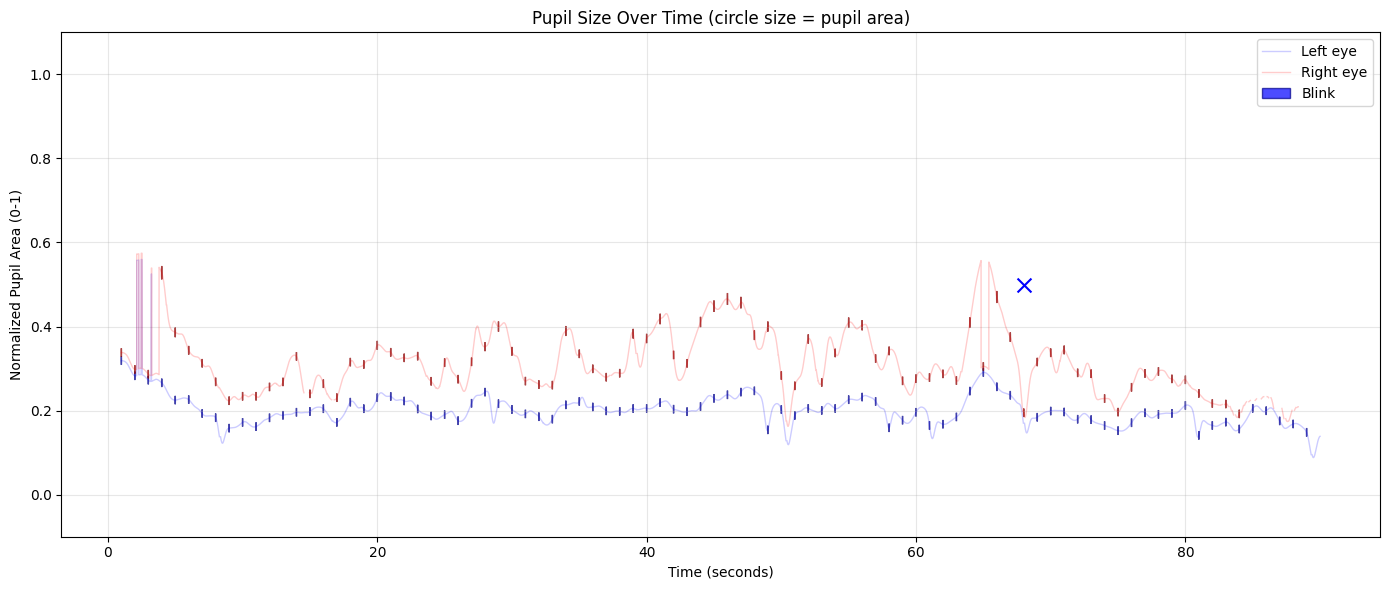

In [27]:
plot_pupil_circles(df_clean_pupil, start_time=0, duration=90, sample_interval=1)

In [53]:
import json

def load_roi_annotations(roi_path):
    """Load and explore ROI annotations"""
    with open(roi_path, 'r') as f:
        roi_data = json.load(f)
    
    # Quick exploration
    print(f"Total frames with annotations: {len(roi_data)}")
    
    # Get all unique ROI labels
    all_labels = set()
    for frame_rois in roi_data.values():
        for roi in frame_rois:
            all_labels.add(roi['label'])
    
    print(f"\nUnique ROI labels found: {sorted(all_labels)}")
    
    # Sample frame analysis
    sample_frame = list(roi_data.keys())[1]
    print(f"\nSample frame {sample_frame} contains {len(roi_data[sample_frame])} ROIs")
    
    return roi_data


In [54]:
roi_annotations = load_roi_annotations('roi.json')

Total frames with annotations: 2697

Unique ROI labels found: ['Bed', 'Couch', 'Face', 'Hand', 'Torso']

Sample frame 1 contains 8 ROIs


In [55]:
def categorize_rois(roi_annotations):
    """Categorize ROIs as social vs non-social"""
    
    roi_categories = {
        'social': ['Face', 'Hand', 'Torso', 'Head', 'Person'],
        'non_social': ['Couch', 'Bed', 'Table', 'Chair', 'Object', 'Toy'],
        'face_parts': ['Face', 'Eyes', 'Mouth']
    }
    
    # Visualize category distribution
    all_rois = []
    for frame_rois in roi_annotations.values():
        for roi in frame_rois:
            all_rois.append(roi['label'])
    
    roi_counts = pd.Series(all_rois).value_counts()
    
    # Create color map
    colors = ['salmon' if label in roi_categories['social'] else 'lightblue' 
              for label in roi_counts.index]
    
    plt.figure(figsize=(10, 6))
    roi_counts.plot(kind='bar', color=colors)
    plt.title('ROI Label Distribution in Video')
    plt.xlabel('ROI Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='salmon', label='Social ROI'),
                      Patch(facecolor='lightblue', label='Non-social ROI')]
    plt.legend(handles=legend_elements)
    plt.tight_layout()
    plt.show()
    
    return roi_categories

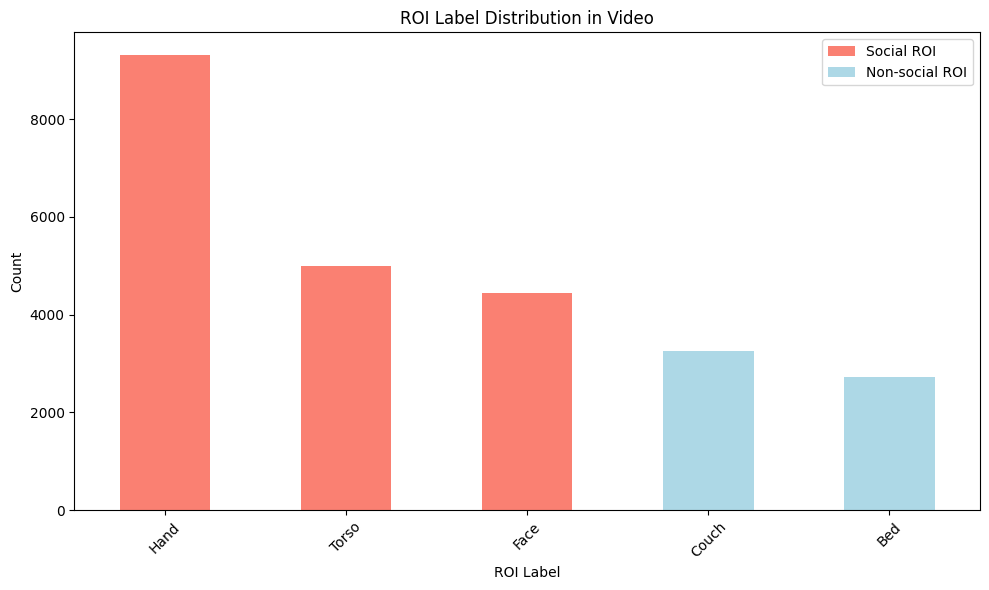

In [56]:
roi_categories = categorize_rois(roi_annotations)

In [67]:
from shapely.geometry import Point, Polygon


def point_in_polygon(x, y, polygon_coords):
    """Check if point (x,y) is inside polygon"""
    polygon_points = [(coord['x'], coord['y']) for coord in polygon_coords]
    polygon = Polygon(polygon_points)
    point = Point(x, y)
    return polygon.contains(point)

def analyze_frame_fixation(gaze_x, gaze_y, frame_rois, roi_categories):
    """Analyze which ROI (if any) contains the gaze point"""
    
    # Normalize coordinates if needed (assuming 1280x1024 screen)
    x_norm = gaze_x / 1280 if gaze_x > 1 else gaze_x
    y_norm = gaze_y / 1024 if gaze_y > 1 else gaze_y
    
    for roi in frame_rois:
        if point_in_polygon(x_norm, y_norm, roi['coordinates']):
            is_social = roi['label'] in roi_categories['social']
            return {
                'roi_label': roi['label'],
                'roi_id': roi['object_id'],
                'is_social': is_social,
                'is_face': roi['label'] == 'Face'
            }
    
    # If not in any ROI
    return {
        'roi_label': 'Background',
        'roi_id': -1,
        'is_social': False,
        'is_face': False
    }

def process_gaze_with_rois(gaze_df, roi_annotations, roi_categories):
    """Process gaze data and assign ROI fixations"""
    
    results = []
    total_rows = len(gaze_df)
    
    # Simple progress tracking
    print(f"Processing {total_rows} gaze samples...")
    
    for idx, row in gaze_df.iterrows():
        # Print progress every 10%
        if idx % (total_rows // 10) == 0:
            print(f"  Progress: {idx/total_rows*100:.0f}%")
        
        # Get frame number (adjust column name as needed)
        frame_num = str(int(row.get('frame_number', 0)))
        
        if frame_num not in roi_annotations:
            continue
        
        # Average both eyes or use specific eye
        x = (row['x_left'] + row['x_right']) / 2
        y = (row['y_left'] + row['y_right']) / 2
        
        # Get ROI fixation
        fixation = analyze_frame_fixation(x, y, roi_annotations[frame_num], roi_categories)
        
        # Add to results
        fixation.update({
            'timestamp': row.get('timestamp', idx),
            'frame': int(frame_num),
            'x_gaze': x,
            'y_gaze': y,
            'subject_id': row.get('subject_id', 'unknown')
        })
        
        results.append(fixation)
    
    print("Processing complete!")
    return pd.DataFrame(results)


In [68]:
# this will take around 20 seconds to run
roi_fixations_df = process_gaze_with_rois(df_clean_pupil, roi_annotations, roi_categories)


Processing 44510 gaze samples...
  Progress: 0%
  Progress: 10%
  Progress: 20%
  Progress: 30%
  Progress: 40%
  Progress: 50%
  Progress: 60%
  Progress: 70%
  Progress: 80%
  Progress: 90%
Processing complete!


In [72]:
def calculate_roi_statistics(roi_df):
    """Calculate comprehensive ROI statistics"""
    
    stats = {
        # Basic proportions
        'total_samples': len(roi_df),
        'social_proportion': roi_df['is_social'].mean(),
        'face_proportion': roi_df['is_face'].mean(),
        'background_proportion': (roi_df['roi_label'] == 'Background').mean(),
        
        # ROI-specific proportions
        'roi_proportions': roi_df['roi_label'].value_counts(normalize=True).to_dict(),
        
        # Fixation durations (consecutive samples on same ROI)
        'fixation_durations': calculate_fixation_durations(roi_df),
        
        # Transition patterns
        'transitions': calculate_transitions(roi_df)
    }
    
    return stats

def calculate_fixation_durations(roi_df):
    """Calculate how long gaze stays on each ROI"""
    
    # Mark when ROI changes
    roi_df['roi_change'] = (roi_df['roi_label'] != roi_df['roi_label'].shift()).cumsum()
    
    # Group by ROI and fixation episode
    durations = {}
    for roi_label in roi_df['roi_label'].unique():
        roi_data = roi_df[roi_df['roi_label'] == roi_label]
        fixation_lengths = roi_data.groupby('roi_change').size()
        
        durations[roi_label] = {
            'mean_samples': fixation_lengths.mean(),
            'mean_ms': fixation_lengths.mean() * 2,  # 500Hz = 2ms per sample
            'max_ms': fixation_lengths.max() * 2,
            'total_ms': len(roi_data) * 2
        }
    
    return durations

def calculate_transitions(roi_df):
    """Calculate transition patterns between ROI types"""
    
    transitions = pd.crosstab(
        roi_df['is_social'].shift(),
        roi_df['is_social'],
        normalize='index'
    )
    
    return transitions.to_dict()

In [76]:
subject_stats = calculate_roi_statistics(roi_fixations_df)

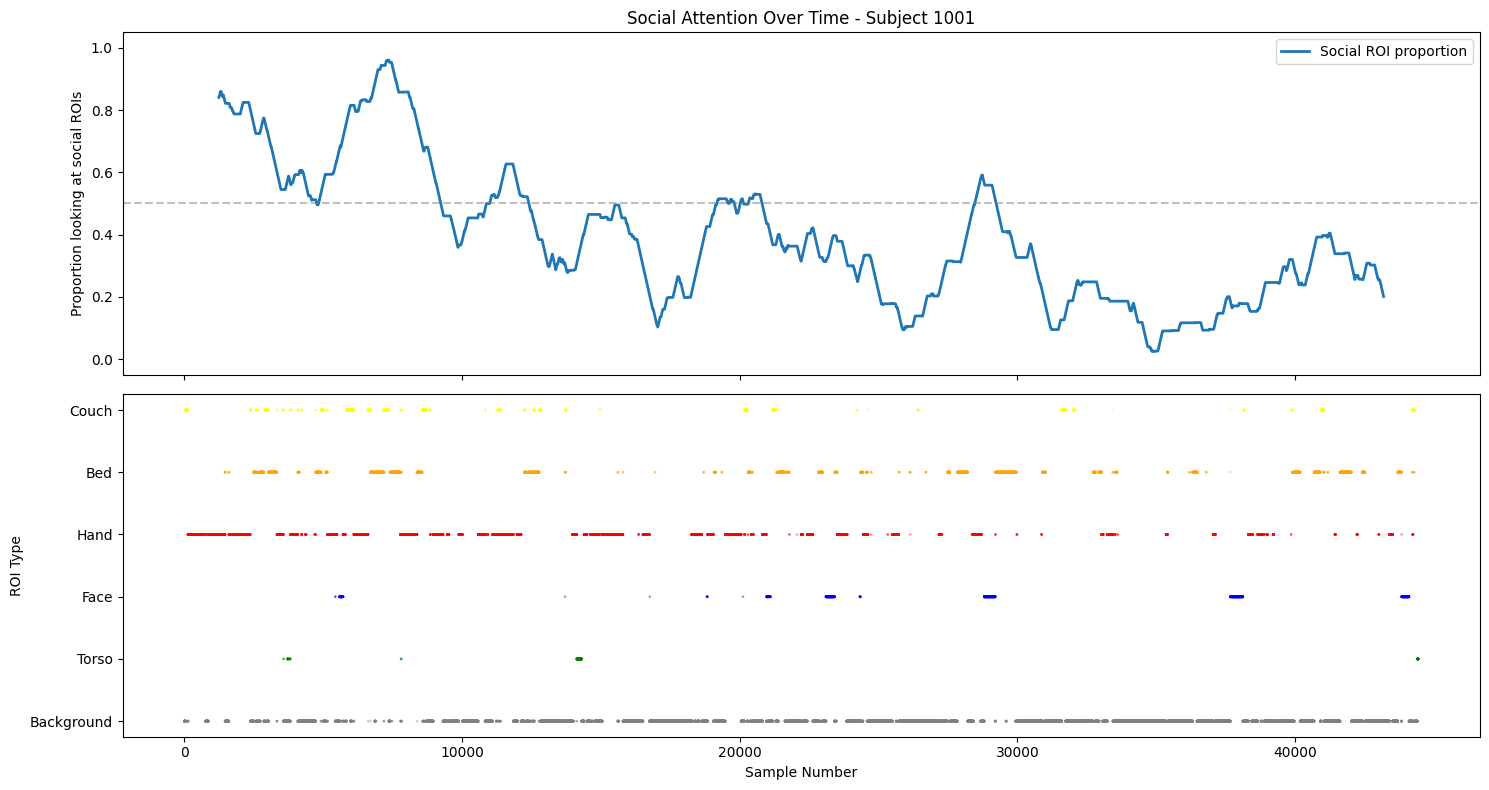

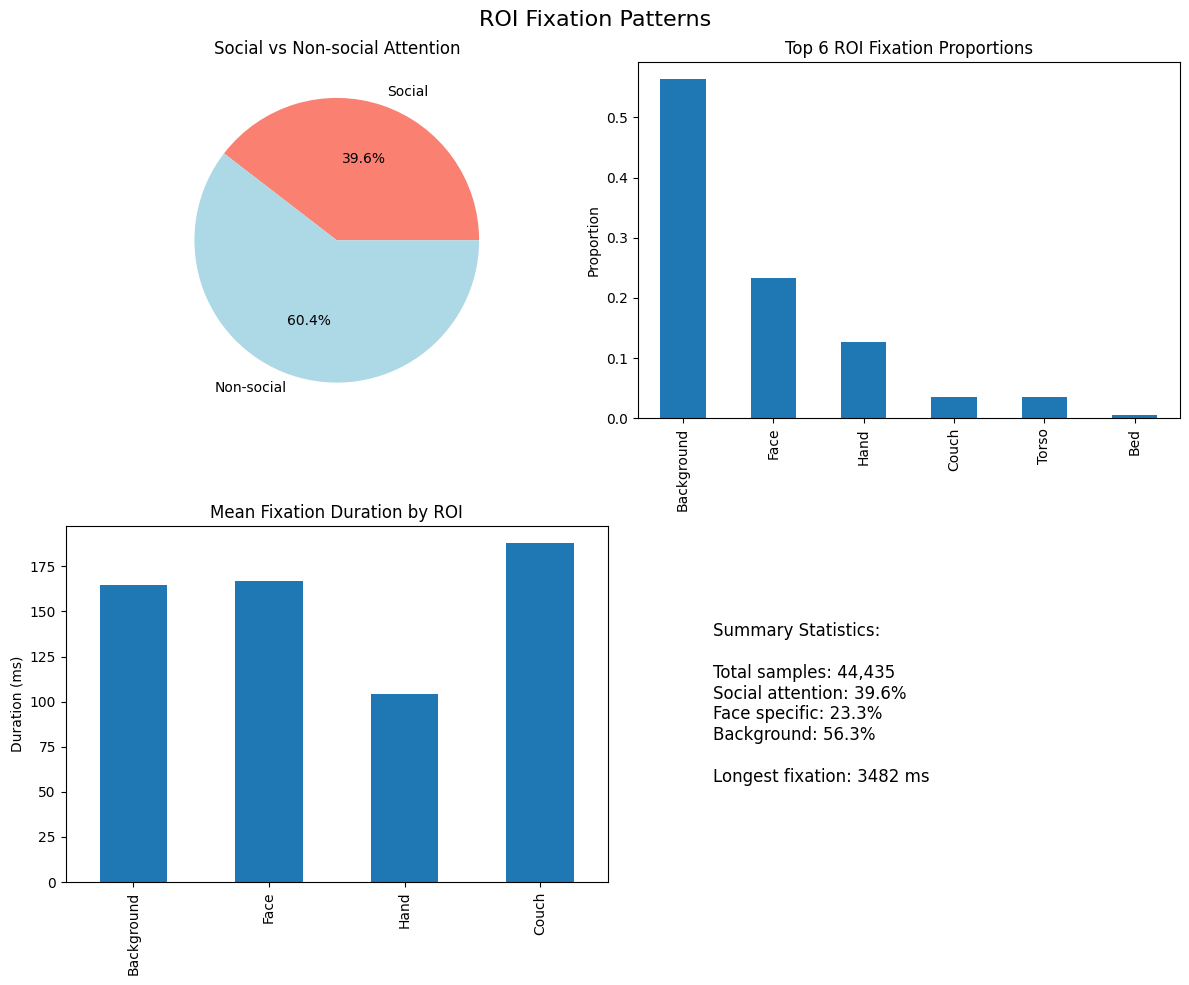

In [75]:
plot_roi_timeline(result2, subject_id="1001")
plot_roi_comparison(subject_stats)

In [ ]:
"Why are you aligning to video frames at all? Your ROIs are annotated at frame level, but is there a principled reason to downsample your gaze data? Consider:
* Could you interpolate ROI positions to 500Hz instead?
* Could your DL model handle variable-rate inputs?
The literature shows that microsaccades and fixational eye movements contain diagnostic information for various conditions (Otero-Millan et al., 2012). By downsampling, you may be discarding clinically relevant signals." 

so ., my current analysis doesn't scale down or anything, this is the flow for now:  from shapely.geometry import Point, Polygon
def point_in_polygon(x, y, polygon_coords):
    """Check if point (x,y) is inside polygon"""
    polygon_points = [(coord['x'], coord['y']) for coord in polygon_coords]
    polygon = Polygon(polygon_points)
    point = Point(x, y)
    return polygon.contains(point)
def analyze_frame_fixation(gaze_x, gaze_y, frame_rois, roi_categories):
    """Analyze which ROI (if any) contains the gaze point"""
    
    # Normalize coordinates if needed (assuming 1280x1024 screen)
    x_norm = gaze_x / 1280 if gaze_x > 1 else gaze_x
    y_norm = gaze_y / 1024 if gaze_y > 1 else gaze_y
    
    for roi in frame_rois:
        if point_in_polygon(x_norm, y_norm, roi['coordinates']):
            is_social = roi['label'] in roi_categories['social']
            return {
                'roi_label': roi['label'],
                'roi_id': roi['object_id'],
                'is_social': is_social,
                'is_face': roi['label'] == 'Face'
            }
    
    # If not in any ROI
    return {
        'roi_label': 'Background',
        'roi_id': -1,
        'is_social': False,
        'is_face': False
    }
def process_gaze_with_rois(gaze_df, roi_annotations, roi_categories):
    """Process gaze data and assign ROI fixations"""
    
    results = []
    total_rows = len(gaze_df)
    
    # Simple progress tracking
    print(f"Processing {total_rows} gaze samples...")
    
    for idx, row in gaze_df.iterrows():
        # Print progress every 10%
        if idx % (total_rows // 10) == 0:
            print(f"  Progress: {idx/total_rows*100:.0f}%")
        
        # Get frame number (adjust column name as needed)
        frame_num = str(int(row.get('frame_number', 0)))
        
        if frame_num not in roi_annotations:
            continue
        
        # Average both eyes or use specific eye
        x = (row['x_left'] + row['x_right']) / 2
        y = (row['y_left'] + row['y_right']) / 2
        
        # Get ROI fixation
        fixation = analyze_frame_fixation(x, y, roi_annotations[frame_num], roi_categories)
        
        # Add to results
        fixation.update({
            'timestamp': row.get('timestamp', idx),
            'frame': int(frame_num),
            'x_gaze': x,
            'y_gaze': y,
            'subject_id': row.get('subject_id', 'unknown')
        })
        
        results.append(fixation)
    
    print("Processing complete!")
    return pd.DataFrame(results)
def calculate_roi_statistics(roi_df):
    """Calculate comprehensive ROI statistics"""
    
    stats = {
        # Basic proportions
        'total_samples': len(roi_df),
        'social_proportion': roi_df['is_social'].mean(),
        'face_proportion': roi_df['is_face'].mean(),
        'background_proportion': (roi_df['roi_label'] == 'Background').mean(),
        
        # ROI-specific proportions
        'roi_proportions': roi_df['roi_label'].value_counts(normalize=True).to_dict(),
        
        # Fixation durations (consecutive samples on same ROI)
        'fixation_durations': calculate_fixation_durations(roi_df),
        
        # Transition patterns
        'transitions': calculate_transitions(roi_df)
    }
    
    return stats
def calculate_fixation_durations(roi_df):
    """Calculate how long gaze stays on each ROI"""
    
    # Mark when ROI changes
    roi_df['roi_change'] = (roi_df['roi_label'] != roi_df['roi_label'].shift()).cumsum()
    
    # Group by ROI and fixation episode
    durations = {}
    for roi_label in roi_df['roi_label'].unique():
        roi_data = roi_df[roi_df['roi_label'] == roi_label]
        fixation_lengths = roi_data.groupby('roi_change').size()
        
        durations[roi_label] = {
            'mean_samples': fixation_lengths.mean(),
            'mean_ms': fixation_lengths.mean() * 2,  # 500Hz = 2ms per sample
            'max_ms': fixation_lengths.max() * 2,
            'total_ms': len(roi_data) * 2
        }
    
    return durations
def calculate_transitions(roi_df):
    """Calculate transition patterns between ROI types"""
    
    transitions = pd.crosstab(
        roi_df['is_social'].shift(),
        roi_df['is_social'],
        normalize='index'
    )
    
    return transitions.to_dict()

def plot_roi_timeline(roi_df, subject_id="", window_size=2500):
    """Plot timeline of ROI fixations"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Plot 1: Social vs Non-social over time
    window = roi_df['is_social'].rolling(window_size, center=True).mean()
    ax1.plot(roi_df.index, window, label='Social ROI proportion', linewidth=2)
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Proportion looking at social ROIs')
    ax1.set_ylim(-0.05, 1.05)
    ax1.legend()
    ax1.set_title(f'Social Attention Over Time - Subject {subject_id}')
    
    # Plot 2: Specific ROIs
    roi_colors = {
        'Face': 'red',
        'Hand': 'orange', 
        'Torso': 'yellow',
        'Background': 'gray',
        'Couch': 'blue',
        'Bed': 'green'
    }
    
    # Create categorical plot
    roi_numeric = pd.Categorical(roi_df['roi_label']).codes
    ax2.scatter(roi_df.index, roi_numeric, c=[roi_colors.get(roi, 'black') 
                for roi in roi_df['roi_label']], alpha=0.3, s=1)
    
    ax2.set_ylabel('ROI Type')
    ax2.set_xlabel('Sample Number')
    ax2.set_yticks(range(len(roi_df['roi_label'].unique())))
    ax2.set_yticklabels(roi_df['roi_label'].unique())
    
    plt.tight_layout()
    plt.show()
def plot_roi_comparison(stats_dict, title="ROI Fixation Patterns"):
    """Compare ROI patterns across subjects or groups"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Social vs Non-social pie chart
    ax = axes[0, 0]
    social_data = [stats_dict['social_proportion'], 
                   1 - stats_dict['social_proportion']]
    ax.pie(social_data, labels=['Social', 'Non-social'], 
           autopct='%1.1f%%', colors=['salmon', 'lightblue'])
    ax.set_title('Social vs Non-social Attention')
    
    # 2. Top ROIs bar chart
    ax = axes[0, 1]
    roi_props = pd.Series(stats_dict['roi_proportions']).sort_values(ascending=False)[:6]
    roi_props.plot(kind='bar', ax=ax)
    ax.set_title('Top 6 ROI Fixation Proportions')
    ax.set_ylabel('Proportion')
    
    # 3. Fixation duration comparison
    ax = axes[1, 0]
    durations = stats_dict['fixation_durations']
    duration_means = {k: v['mean_ms'] for k, v in durations.items() 
                     if k in ['Face', 'Hand', 'Background', 'Couch']}
    pd.Series(duration_means).plot(kind='bar', ax=ax)
    ax.set_title('Mean Fixation Duration by ROI')
    ax.set_ylabel('Duration (ms)')
    
    # 4. Summary text
    ax = axes[1, 1]
    ax.axis('off')
    summary_text = f"""
    Summary Statistics:
    
    Total samples: {stats_dict['total_samples']:,}
    Social attention: {stats_dict['social_proportion']:.1%}
    Face specific: {stats_dict['face_proportion']:.1%}
    Background: {stats_dict['background_proportion']:.1%}
    
    Longest fixation: {max(d['max_ms'] for d in durations.values()):.0f} ms
    """
    ax.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


but is believe it is a bit flawed